# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import copy
import torch
import random
import torchvision
import numpy as np
from torch import nn
from torch import optim
from sklearn import metrics
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_id = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_size = 40000
val_size = 10000
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

cifar100_full = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
print(train_dataset_full.classes)
print(cifar100_full.classes)

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]
100%|██████████| 169M/169M [00:01<00:00, 87.2MB/s]


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', '

In [3]:
#Individuo le classi non comuni a CIFAR10 e CIFAR100, seleziono 10 classi in maniera casuale, individuo gli indici delle classi selezionate e creo un sottoinsieme
#del dataset CIFAR100 con le classi selezionate.
different_classes = [cls for cls in cifar100_full.classes if cls not in train_dataset_full.classes]
selected_classes = random.sample(different_classes, 10)
class_to_idx = {cifar100_full.classes[i]: i for i in range(len(cifar100_full.classes))}
selected_class_indices = [class_to_idx[class_name] for class_name in selected_classes]
indices = []
for i, (_, label) in enumerate(cifar100_full):
    if label in selected_class_indices:
        indices.append(i)
test_dataset_ood = Subset(cifar100_full, indices)

#Creazione dei data loader.
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader_id = DataLoader(test_dataset_id, batch_size=batch_size, shuffle=False)
test_loader_ood = DataLoader(test_dataset_ood, batch_size=batch_size, shuffle=False)

In [4]:
#Creazione di una semplice rete convoluzionale.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
#Definisco due funzioni: una per l'addestramento del modello e l'altra per la valutazione del modello.
#Definisco, inoltre, una funzione per il plot degli istogrammi e degli score ordinati.
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        pred = model(data)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1)==labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def evaluate(model, validation_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in validation_loader:
            data, labels = data.to(device), labels.to(device)
            pred = model(data)
            loss = criterion(pred, labels)

            total_loss += loss.item()
            correct += (pred.argmax(1)==labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(validation_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def plot_scores(scores_id_msp, scores_ood_msp, scores_id_logit, scores_ood_logit):
    fig, axes = plt.subplots(2, 2, figsize=(15,10))

    axes[0, 0].hist(scores_id_msp, density=True, alpha=0.7, bins=25,
                    label='ID (CIFAR-10)', color='blue')
    axes[0, 0].hist(scores_ood_msp, density=True, alpha=0.7, bins=25,
                    label='OOD (CIFAR-100)', color='red')
    axes[0, 0].set_title('Max Softmax Probability Distribution')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()

    axes[1, 0].plot(sorted(scores_id_msp), label='ID (CIFAR-10)', color='blue')
    axes[1, 0].plot(sorted(scores_ood_msp), label='OOD (CIFAR-100)', color='red')
    axes[1, 0].set_title('Sorted Max Softmax Scores')
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()

    axes[0, 1].hist(scores_id_logit, density=True, alpha=0.7, bins=25,
                    label='ID (CIFAR-10)', color='blue')
    axes[0, 1].hist(scores_ood_logit, density=True, alpha=0.7, bins=25,
                    label='OOD (CIFAR-100)', color='red')
    axes[0, 1].set_title('Max Logit Distribution')
    axes[0, 1].set_xlabel('Score')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()

    axes[1, 1].plot(sorted(scores_id_logit), label='ID (CIFAR-10)', color='blue')
    axes[1, 1].plot(sorted(scores_ood_logit), label='OOD (CIFAR-100)', color='red')
    axes[1, 1].set_title('Sorted Max Logit Scores')
    axes[1, 1].set_xlabel('Sample Index')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [6]:
#Addestro il modello definendo la loss, l'ottimizzatore, il learning rate e il numero di epoche.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1:2d}/{epochs}: '
      f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:5.2f}% | '
      f'Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:5.2f}%')

Epoch  1/20: Train Loss: 1.8040, Train Acc: 34.16% | Validation Loss: 1.5844, Val Acc: 42.81%
Epoch  2/20: Train Loss: 1.4776, Train Acc: 46.69% | Validation Loss: 1.4341, Val Acc: 47.79%
Epoch  3/20: Train Loss: 1.3597, Train Acc: 50.87% | Validation Loss: 1.3456, Val Acc: 51.41%
Epoch  4/20: Train Loss: 1.2831, Train Acc: 53.86% | Validation Loss: 1.3178, Val Acc: 53.02%
Epoch  5/20: Train Loss: 1.2293, Train Acc: 56.05% | Validation Loss: 1.2614, Val Acc: 54.85%
Epoch  6/20: Train Loss: 1.1770, Train Acc: 58.04% | Validation Loss: 1.2360, Val Acc: 56.32%
Epoch  7/20: Train Loss: 1.1376, Train Acc: 59.36% | Validation Loss: 1.2041, Val Acc: 57.18%
Epoch  8/20: Train Loss: 1.0989, Train Acc: 60.92% | Validation Loss: 1.2001, Val Acc: 57.83%
Epoch  9/20: Train Loss: 1.0706, Train Acc: 62.05% | Validation Loss: 1.1775, Val Acc: 58.43%
Epoch 10/20: Train Loss: 1.0424, Train Acc: 63.14% | Validation Loss: 1.1865, Val Acc: 58.63%
Epoch 11/20: Train Loss: 1.0124, Train Acc: 64.27% | Validat

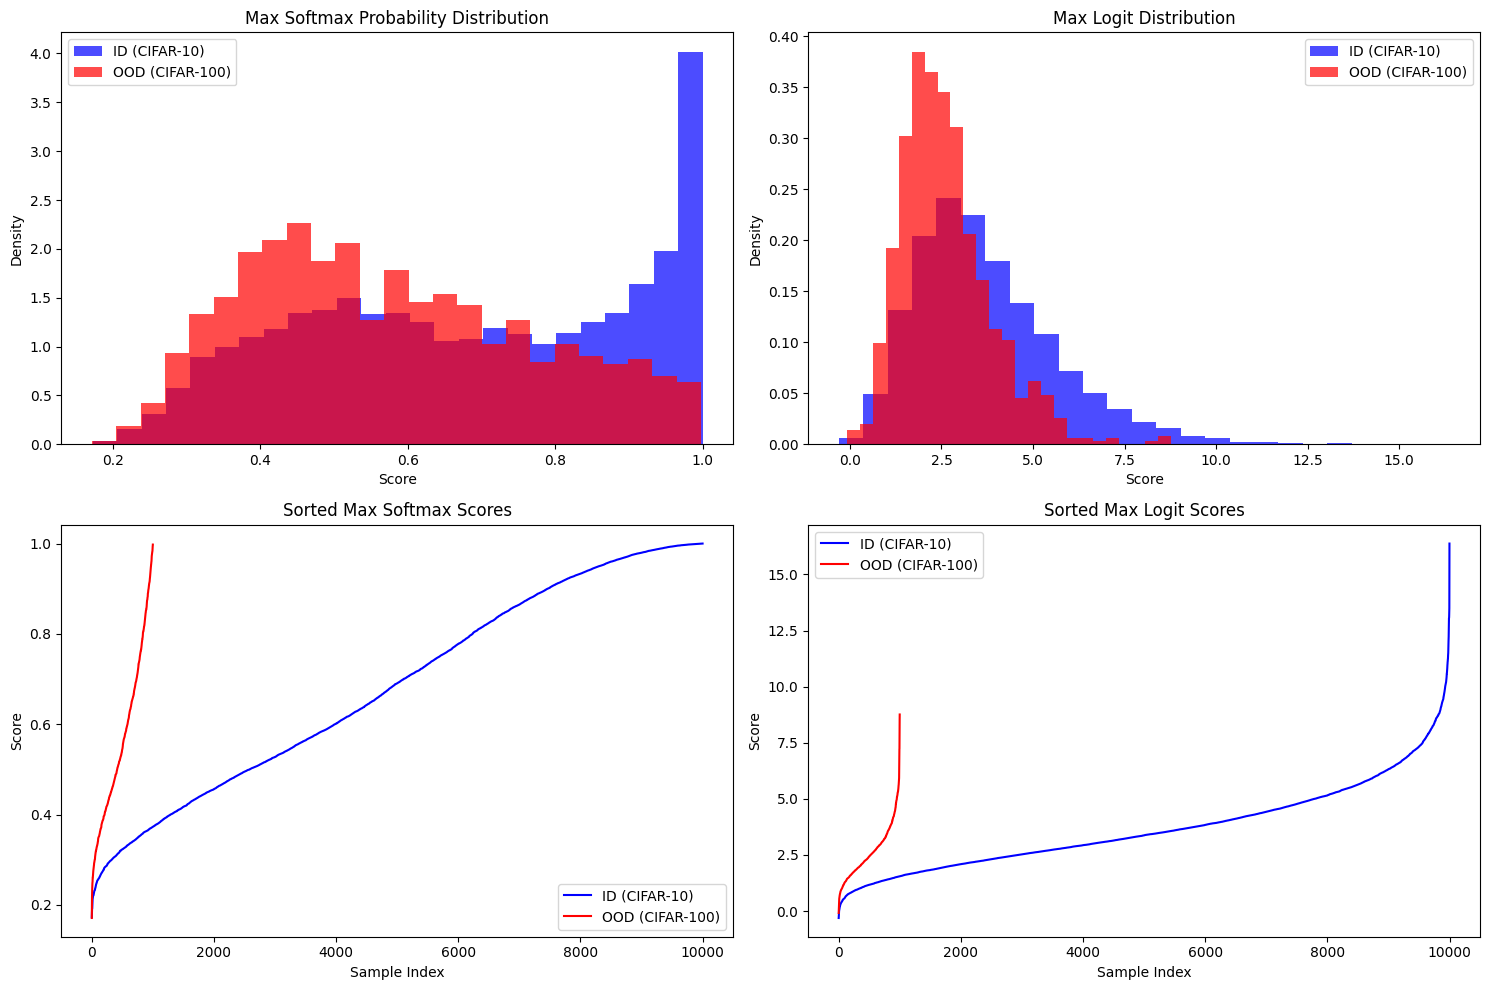

In [7]:
#Definisco una funzione per calcolare gli score sulla base di max_softmax o max_logit.
def compute_scores(model, dataloader, function_type):
  model.eval()
  scores = []
  with torch.no_grad():
      for data, _ in dataloader:
          data = data.to(device)
          logits = model(data)

          if function_type == "max_softmax":
              probs = torch.softmax(logits, dim=1)
              score = torch.max(probs, dim=1)[0]
          elif function_type == "max_logit":
              score = torch.max(logits, dim=1)[0]
          scores.append(score.cpu())
  return torch.cat(scores)

#Calcolo gli score per i due metodi indicati precedentemente.
scores_id_msp = compute_scores(model, test_loader_id, "max_softmax")
scores_ood_msp = compute_scores(model, test_loader_ood, "max_softmax")

scores_id_logit = compute_scores(model, test_loader_id, "max_logit")
scores_ood_logit = compute_scores(model, test_loader_ood, "max_logit")

plot_scores(scores_id_msp.cpu(), scores_ood_msp.cpu(), scores_id_logit.cpu(), scores_ood_logit.cpu())

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



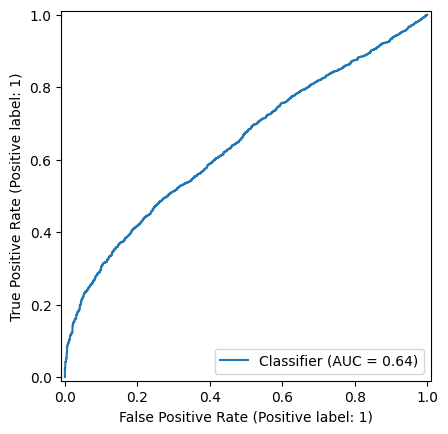

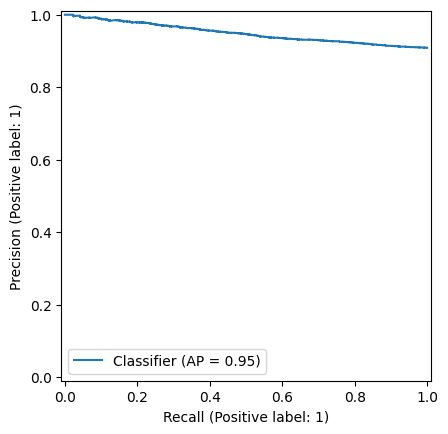

In [8]:
scores = np.concatenate([scores_id_msp, scores_ood_msp])
labels = np.concatenate([np.ones(len(scores_id_msp)), np.zeros(len(scores_ood_msp))])

metrics.RocCurveDisplay.from_predictions(labels, scores)
metrics.PrecisionRecallDisplay.from_predictions(labels, scores)

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [14]:
#Creo una funzione per generare esempi adversarial.
def generate_adversarial_example(model, x, y, epsilon, criterion):
    model.eval()
    x = x.to(device)
    y = y.to(device)
    x_adv = x.clone().detach().requires_grad_(True)

    preds = model(x_adv)
    loss = criterion(preds, y)

    model.zero_grad()
    loss.backward()

    data_grad = x_adv.grad.data
    perturbation = epsilon * data_grad.sign() #calcolo la perturbazione in base alla formula FGSM

    x_adv = x + perturbation
    x_adv = torch.clamp(x_adv, -1, 1) #per coerenza con la normalizzazione dei dati
    return x_adv.detach()

#Creo una funzione per valutare il tasso di successo di un attacco.
def evaluate_attack(model, x_orig, x_adv, y_true):
    x_orig = x_orig.to(device)
    x_adv = x_adv.to(device)
    y_true = y_true.to(device)

    with torch.no_grad():

        pred_orig = model(x_orig)
        pred_adv = model(x_adv)

        pred_orig_class = torch.argmax(pred_orig, dim=1)
        pred_adv_class = torch.argmax(pred_adv, dim=1)

        orig_accuracy = (pred_orig_class == y_true).float().mean().item()
        adv_accuracy = (pred_adv_class == y_true).float().mean().item()
        attack_success_rate = (pred_orig_class != pred_adv_class).float().mean().item()

    return {
        'Original accuracy': orig_accuracy,
        'Adversarial accuracy': adv_accuracy,
        'Attack success rate': attack_success_rate,
    }

#Creo una funzione per valutare come variano l'accuracy e il tasso di successo di un attacco al variare di epsilon.
def evaluate_epsilon(model, data_loader, epsilons, criterion):
    results = []
    data_iter = iter(data_loader)
    x_batch, y_batch = next(data_iter)

    for epsilon in epsilons:
        x_adv = generate_adversarial_example(model, x_batch, y_batch, epsilon, criterion)
        metrics = evaluate_attack(model, x_batch, x_adv, y_batch)
        metrics['epsilon'] = epsilon
        results.append(metrics)

    return results

def evaluate_robustness(model, test_loader, epsilon=0.01):
    model.eval()
    correct_clean = 0
    correct_adv = 0
    total = 0

    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        with torch.no_grad(): #calcolo l'accuracy clean
            outputs_clean = model(x_batch)
            _, pred_clean = torch.max(outputs_clean, 1)
            correct_clean += (pred_clean == y_batch).sum().item()

        x_adv = generate_adversarial_example(model, x_batch, y_batch, epsilon, criterion)

        with torch.no_grad(): #calcolo l'accuracy adversarial
            outputs_adv = model(x_adv)
            _, pred_adv = torch.max(outputs_adv, 1)
            correct_adv += (pred_adv == y_batch).sum().item()

        total += y_batch.size(0)

    return correct_clean/total, correct_adv/total

In [35]:
#Valuto le funzioni definite precedentemente su 20 esempi.
base_model = copy.deepcopy(model)
data_iter = iter(test_loader_id)
test_images, test_labels = next(data_iter)

n_examples = 20
test_images = test_images[:n_examples]
test_labels = test_labels[:n_examples]

epsilon = 0.01
x_adv = generate_adversarial_example(base_model, test_images, test_labels, epsilon, criterion)
results = evaluate_attack(base_model, test_images, x_adv, test_labels)
for key, value in results.items():
    print(f"  {key}: {value:.3f}")

epsilons = [0.0, 0.001, 0.003, 0.005, 0.01, 0.015, 0.02, 0.03]
results = evaluate_epsilon(base_model, test_loader_id, epsilons, criterion)

for r in results:
    print(f"ε={r['epsilon']:.3f}: "
          f"Success={r['Attack success rate']:.1%}, "
          f"Original accuracy={r['Original accuracy']:.1%}, "
          f"Adversarial accuracy={r['Adversarial accuracy']:.1%}")


  Original accuracy: 0.700
  Adversarial accuracy: 0.450
  Attack success rate: 0.250
ε=0.000: Success=0.0%, Original accuracy=60.9%, Adversarial accuracy=60.9%
ε=0.001: Success=0.8%, Original accuracy=60.9%, Adversarial accuracy=60.2%
ε=0.003: Success=7.0%, Original accuracy=60.9%, Adversarial accuracy=53.9%
ε=0.005: Success=13.3%, Original accuracy=60.9%, Adversarial accuracy=47.7%
ε=0.010: Success=26.6%, Original accuracy=60.9%, Adversarial accuracy=35.2%
ε=0.015: Success=35.2%, Original accuracy=60.9%, Adversarial accuracy=27.3%
ε=0.020: Success=43.0%, Original accuracy=60.9%, Adversarial accuracy=19.5%
ε=0.030: Success=54.7%, Original accuracy=60.9%, Adversarial accuracy=9.4%


Questi risultati mostrano che all'aumentare di epsilon il modello diventa sempre più vulnerabile agli attacchi. Di conseguenza questo modello non è abbastanza robusto agli attacchi.

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [27]:
def train_fgsm(model, train_loader, optimizer, criterion, device, epsilon=0.01, epochs=10, prob=0.5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            batch_size = x_batch.size(0)

            mask = torch.rand(batch_size) < prob #individua alcuni esempi da rendere adversarial

            if mask.any():
                x_adv = x_batch[mask].clone().detach().requires_grad_(True) #genera esempi adversarial con gli indici selezionati
                y_adv = y_batch[mask]

                model.eval()
                outputs_grad = model(x_adv)
                loss_grad = criterion(outputs_grad, y_adv)
                loss_grad.backward()

                # Genera esempi adversariali
                with torch.no_grad():
                    x_adv_generated = torch.clamp(x_adv + epsilon * x_adv.grad.sign(), -1, 1)
                    x_batch[mask] = x_adv_generated #sostituisce gli esempi selezionati con quelli adversarial

            model.train()
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.4f}")

In [12]:
#Addestramento del modello con esempi adversarial.
fgsm_model = CNN().to(device)
optimizer = optim.Adam(fgsm_model.parameters(), lr=0.001)

train_fgsm(fgsm_model, train_loader, optimizer, criterion, device)

Epoch 1/10, Loss: 1.8336, Accuracy: 0.3221
Epoch 2/10, Loss: 1.5662, Accuracy: 0.4248
Epoch 3/10, Loss: 1.4735, Accuracy: 0.4651
Epoch 4/10, Loss: 1.4119, Accuracy: 0.4863
Epoch 5/10, Loss: 1.3604, Accuracy: 0.5056
Epoch 6/10, Loss: 1.3215, Accuracy: 0.5212
Epoch 7/10, Loss: 1.2893, Accuracy: 0.5323
Epoch 8/10, Loss: 1.2594, Accuracy: 0.5419
Epoch 9/10, Loss: 1.2298, Accuracy: 0.5537
Epoch 10/10, Loss: 1.2046, Accuracy: 0.5665


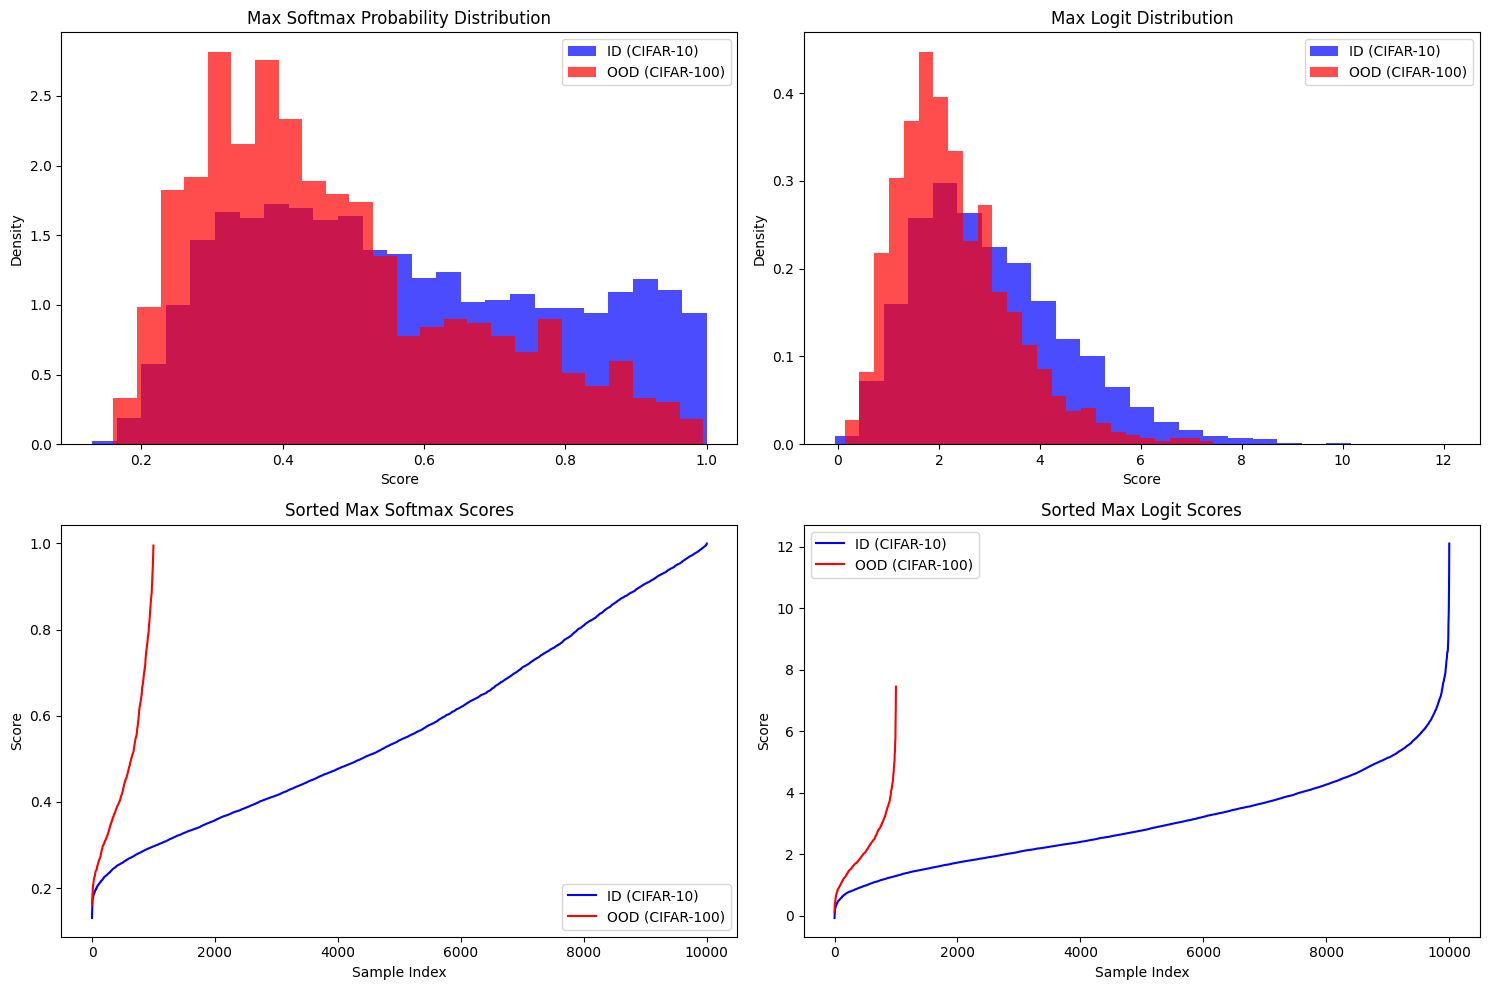

Base model clean accuracy: 0.6110
Base model adversarial accuracy: 0.3753
FGSM model clean accuracy: 0.5897
FGSM model adversarial accuracy: 0.4805


In [17]:
#Calcolo degli score per il nuovo modello.
scores_id_msp_fgsm = compute_scores(fgsm_model, test_loader_id, "max_softmax")
scores_ood_msp_fgsm = compute_scores(fgsm_model, test_loader_ood, "max_softmax")

scores_id_logit_fgsm = compute_scores(fgsm_model, test_loader_id, "max_logit")
scores_ood_logit_fgsm = compute_scores(fgsm_model, test_loader_ood, "max_logit")
plot_scores(scores_id_msp_fgsm.cpu(), scores_ood_msp_fgsm.cpu(), scores_id_logit_fgsm.cpu(), scores_ood_logit_fgsm.cpu())

#Confronto dell'accuracy clean e dell'accuracy adversarial del modello base e del modello fgsm.
base_model_clean_acc, base_model_adv_acc = evaluate_robustness(model, test_loader_id)
print(f"Base model clean accuracy: {base_model_clean_acc:.4f}")
print(f"Base model adversarial accuracy: {base_model_adv_acc:.4f}")

fgsm_model_clean_acc, fgsm_model_adv_acc = evaluate_robustness(fgsm_model, test_loader_id)
print(f"FGSM model clean accuracy: {fgsm_model_clean_acc:.4f}")
print(f"FGSM model adversarial accuracy: {fgsm_model_adv_acc:.4f}")

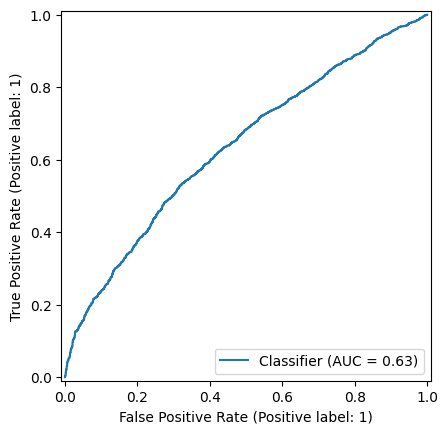

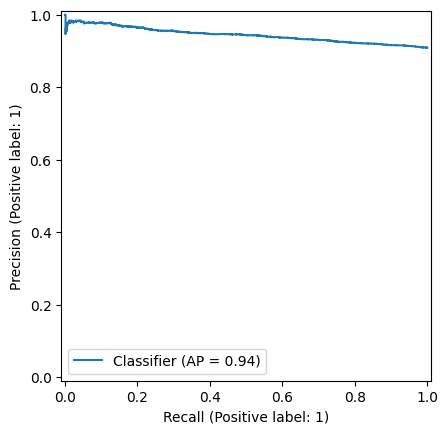

In [18]:
scores_fgsm = np.concatenate([scores_id_msp_fgsm, scores_ood_msp_fgsm])
labels_fgsm = np.concatenate([np.ones(len(scores_id_msp_fgsm)), np.zeros(len(scores_ood_msp_fgsm))])
metrics.RocCurveDisplay.from_predictions(labels_fgsm, scores_fgsm)
metrics.PrecisionRecallDisplay.from_predictions(labels_fgsm, scores_fgsm)

Dopo aver addestrato il modello adversarial si osserva che la robustezza nei confronti degli attacchi è migliorata significativamente a discapito di una piccola perdita di accuracy sui dati ID.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [36]:
def odin_score(model, x, T=1000, epsilon=0.001):
    model.eval()
    x = x.to(device)
    x.requires_grad_(True)

    logits = model(x)
    probs = torch.softmax(logits / T, dim=1) #temperature scaling
    _, pred_label = torch.max(probs, dim=1)

    log_probs = torch.log(probs + 1e-12) #calcolo delle log-probabilità
    selected = log_probs[torch.arange(x.size(0)), pred_label].sum() #selezione delle log-probabilità delle classi predette

    model.zero_grad()
    if x.grad is not None:
        x.grad.zero_()
    selected.backward()
    grad = x.grad.detach()

    x_perturbed = x - epsilon * torch.sign(-grad) #applicazione della perturbazione
    x_perturbed = torch.clamp(x_perturbed, -1, 1) #per mantenere coerenza con i dati normalizzati

    with torch.no_grad():
        logits = model(x_perturbed)
        probs = torch.softmax(logits / T, dim=1)
        odin_scores, _ = torch.max(probs, dim=1)

    return odin_scores

temperatures = [1, 10, 100, 1000]
epsilons = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]

best_auc = 0
best_temperature = 0
best_epsilon = 0

for T in temperatures:
    for eps in epsilons:
        scores_id = []
        scores_ood = []

        for x, _ in test_loader_id:
            s = odin_score(model, x, T=T, epsilon=eps)
            scores_id.extend(s.cpu().numpy())

        for x, _ in test_loader_ood:
            s = odin_score(model, x, T=T, epsilon=eps)
            scores_ood.extend(s.cpu().numpy())

        scores = np.concatenate([scores_id, scores_ood])
        labels = np.concatenate([np.ones(len(scores_id)), np.zeros(len(scores_ood))])
        auc = metrics.roc_auc_score(labels, scores)

        print(f"T={T}, eps={eps} → AUROC={auc:.4f}")

        if auc > best_auc:
            best_auc, best_temperature, best_epsilon = auc, T, eps
print("Best temperature:", best_temperature, "Best epsilon:", best_epsilon, "Best AUC:", best_auc)

T=1, eps=0 → AUROC=0.6427
T=1, eps=0.001 → AUROC=0.6441
T=1, eps=0.002 → AUROC=0.6454
T=1, eps=0.005 → AUROC=0.6485
T=1, eps=0.01 → AUROC=0.6515
T=1, eps=0.02 → AUROC=0.6530
T=1, eps=0.05 → AUROC=0.6468
T=1, eps=0.1 → AUROC=0.6356
T=1, eps=0.15 → AUROC=0.6298
T=1, eps=0.2 → AUROC=0.6239
T=10, eps=0 → AUROC=0.6761
T=10, eps=0.001 → AUROC=0.6768
T=10, eps=0.002 → AUROC=0.6775
T=10, eps=0.005 → AUROC=0.6792
T=10, eps=0.01 → AUROC=0.6812
T=10, eps=0.02 → AUROC=0.6833
T=10, eps=0.05 → AUROC=0.6828
T=10, eps=0.1 → AUROC=0.6747
T=10, eps=0.15 → AUROC=0.6663
T=10, eps=0.2 → AUROC=0.6570
T=100, eps=0 → AUROC=0.6774
T=100, eps=0.001 → AUROC=0.6782
T=100, eps=0.002 → AUROC=0.6790
T=100, eps=0.005 → AUROC=0.6809
T=100, eps=0.01 → AUROC=0.6833
T=100, eps=0.02 → AUROC=0.6862
T=100, eps=0.05 → AUROC=0.6872
T=100, eps=0.1 → AUROC=0.6795
T=100, eps=0.15 → AUROC=0.6699
T=100, eps=0.2 → AUROC=0.6601
T=1000, eps=0 → AUROC=0.6775
T=1000, eps=0.001 → AUROC=0.6783
T=1000, eps=0.002 → AUROC=0.6790
T=1000, eps

L'utilizzo di ODIN per l'ood detection porta ad un miglioramento rispetto al modello base. In particolare, si osserva che l'aumento della temperatura porta a miglioramenti consistenti delle performance.